In [2]:
import pandas as pd
import seaborn as sns
import glob, os
import re

In [3]:
results_path = "results/"
results = []

for filename in glob.glob(results_path + "*.json"):
    df = pd.read_json(filename).T
    orig_bt_df = df[df["is_generated"] & df["is_original_bt_espresso"]]
    re_bt_df = df[df["is_generated"] & ~df["is_original_bt_espresso"]]
    print(filename)
    num_sim_nodes = df[df["is_generated"] == False].values[0][3]
    expr_num = re.findall(r'\d+', filename)[0]
    results.append({"num_sim_nodes" : num_sim_nodes, "exprnum" : expr_num , "re_bt" : True, "min" : re_bt_df.graph_edit_distance.min(), "mean" : re_bt_df.graph_edit_distance.min(), "std" : re_bt_df.graph_edit_distance.std(), "median" : re_bt_df.graph_edit_distance.median()})
    results.append({"num_sim_nodes" : num_sim_nodes,"exprnum" : expr_num, "re_bt" : False, "min" : orig_bt_df.graph_edit_distance.min(), "mean" : orig_bt_df.graph_edit_distance.min(), "std" : orig_bt_df.graph_edit_distance.std(), "median" : orig_bt_df.graph_edit_distance.median()})


In [4]:
result_df = pd.DataFrame(results)
result_df

,num_sim_nodes,exprnum,re_bt,min,mean,std,median
0,8,1,True,9.0,9.0,1.531214,13.0
1,8,1,False,10.0,10.0,1.331858,13.0
2,5,3,True,5.0,5.0,3.815136,8.0
3,5,3,False,6.0,6.0,3.471690,8.0
4,10,0,True,14.0,14.0,0.852147,15.0
5,10,0,False,14.0,14.0,1.497177,18.0
6,3,2,True,0.0,0.0,NaN,0.0
7,3,2,False,2.0,2.0,NaN,2.0
8,8,4,True,7.0,7.0,2.645751,12.0
9,8,4,False,12.0,12.0,0.500000,12.0


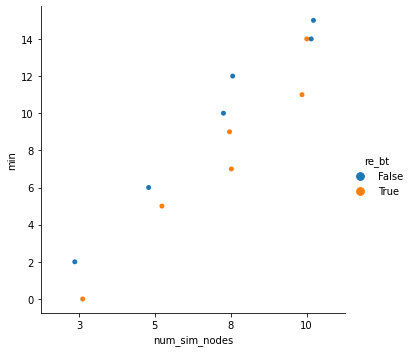

In [6]:
sns.catplot(x="num_sim_nodes", y="min", hue="re_bt", ci="std", data=result_df)